# BERT Baseline for Figurative Language Understanding

In this notebook, we prepare a BERT-based baseline model for the BESSTIE dataset.
We use the preprocessed encoder-ready data produced earlier and focus on:

- Loading preprocessed tensors
- Understanding their structure
- Preparing datasets and dataloaders
- Verifying that everything is ready for training

## Imports and environment setup

We import the libraries required for:
- loading PyTorch tensors
- building datasets and dataloaders
- defining a BERT classification model
- basic evaluation utilities

No training is performed yet.

In [ ]:
# Core libraries
import torch
import numpy as np
import random

# PyTorch utilities
from torch.utils.data import Dataset, DataLoader

# Hugging Face model
from transformers import BertForSequenceClassification

# Metrics
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch version: 2.9.0+cu126
CUDA available: True


## Reproducibility

We fix random seeds to ensure reproducible results.
This is important for fair comparison with other models and experiments.

In [ ]:
# Fix random seeds
SEED = 50

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Random seeds fixed.")

Random seeds fixed.


In [ ]:
# Simple check: generate a random number twice
print(np.random.rand())
print(np.random.rand())

0.49460164553802144
0.22808310444933622


## Loading preprocessed encoder data

We load the encoder-ready tensors created during preprocessing.
These tensors already include:
- input_ids
- attention_mask
- labels

The data is split into train, validation, and test sets.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive mounted.")

Mounted at /content/drive
Google Drive mounted.


In [ ]:
# Path to preprocessed data
DATA_PATH = "/content/drive/MyDrive/DNLP/data/processed_data/sarcasm_bert_encoder_data.pt"

# Load the data
encoder_data = torch.load(DATA_PATH)

print("Keys in loaded data:", encoder_data.keys())

Keys in loaded data: dict_keys(['train', 'val', 'test'])


In [ ]:
# Check split sizes
for split in encoder_data:
    print(
        split,
        encoder_data[split]["input_ids"].shape,
        encoder_data[split]["labels"].shape
    )

train torch.Size([8004, 256]) torch.Size([8004])
val torch.Size([890, 256]) torch.Size([890])
test torch.Size([1216, 256]) torch.Size([1216])


## Inspecting tensor structure

Before modeling, we inspect the shape and content of tensors
to confirm that preprocessing was applied correctly.

We check:
- sequence length (max_length)
- label format
- attention masks

In [ ]:
# Inspect one training example
sample_input_ids = encoder_data["train"]["input_ids"][0]
sample_attention_mask = encoder_data["train"]["attention_mask"][0]
sample_label = encoder_data["train"]["labels"][0]

print("Input IDs shape:", sample_input_ids.shape)
print("Attention mask shape:", sample_attention_mask.shape)
print("Label:", sample_label)

Input IDs shape: torch.Size([256])
Attention mask shape: torch.Size([256])
Label: tensor(0)


In [ ]:
sample_input_ids

tensor([  101, 12941,  1149,  1128, 11078,  2118,  1116,   178,  1567,  1115,
         1282,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [ ]:
sample_attention_mask

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
sample_label

tensor(0)

In [ ]:
# Verify attention mask consistency
print("Number of real tokens:", sample_attention_mask.sum().item())
print("Total sequence length:", sample_attention_mask.shape[0])

Number of real tokens: 12
Total sequence length: 256


## Dataset class

We define a simple PyTorch Dataset to wrap the preprocessed tensors.
This allows us to use PyTorch DataLoader for batching.

The dataset does NOT perform tokenization.
It only returns already-prepared tensors.

In [ ]:
class BertDataset(Dataset):
    def __init__(self, split_data):
        self.input_ids = split_data["input_ids"]
        self.attention_mask = split_data["attention_mask"]
        self.labels = split_data["labels"]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }

In [ ]:
train_dataset = BertDataset(encoder_data["train"])
print("Number of training samples:", len(train_dataset))
print("Keys returned by dataset:", train_dataset[0].keys())

Number of training samples: 8004
Keys returned by dataset: dict_keys(['input_ids', 'attention_mask', 'labels'])


## DataLoaders

We create DataLoaders for batching.
At this stage, we only test small batches to verify correctness.

In [ ]:
BATCH_SIZE = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print("Train DataLoader ready.")

Train DataLoader ready.


In [ ]:
# Fetch one batch
batch = next(iter(train_loader))

for key in batch:
    print(key, batch[key].shape)

input_ids torch.Size([8, 256])
attention_mask torch.Size([8, 256])
labels torch.Size([8])


## Loading BERT for sequence classification

We load a pretrained BERT model with a classification head.
The model is configured for binary classification.

No training is performed in this cell.

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels=2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model loaded on device:", device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on device: cuda


In [ ]:
# Count trainable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {num_params:,}")

Trainable parameters: 108,311,810


## Sanity check: forward pass

Before training, we perform a single forward pass on one batch.
This ensures:
- no shape mismatch
- no device errors
- correct output format

In [ ]:
model.eval()

batch = next(iter(train_loader))

with torch.no_grad():
    outputs = model(
        input_ids=batch["input_ids"].to(device),
        attention_mask=batch["attention_mask"].to(device),
        labels=batch["labels"].to(device)
    )

print("Loss:", outputs.loss.item())
print("Logits shape:", outputs.logits.shape)

Loss: 1.0415092706680298
Logits shape: torch.Size([8, 2])


In [ ]:
# Check that logits match expected shape
assert outputs.logits.shape[1] == 2
print("Forward pass successful. Shapes are correct.")

Forward pass successful. Shapes are correct.


## Status

At this point:
- Data loading is correct
- Tensor shapes are consistent
- DataLoaders work as expected
- BERT forward pass runs without errors

The notebook is ready for:
- defining loss functions (weighted or focal)
- training loop
- evaluation

We intentionally stop here before any heavy computation.

## Loading precomputed class weights

Class weights were computed during preprocessing and saved to ensure
consistent handling of class imbalance across experiments.

We load and reuse these weights here.

In [ ]:
# Load class weights saved during preprocessing
WEIGHTS_PATH = "/content/drive/MyDrive/DNLP/data/processed_data/sarcasm_weights.pt"
class_weights = torch.load(WEIGHTS_PATH).to(device)

print("Loaded class weights:", class_weights)

Loaded class weights: tensor([0.5836, 3.4891], device='cuda:0')


In [ ]:
assert class_weights.shape[0] == 2
assert class_weights.min() > 0
print("Precomputed class weights verified.")

Precomputed class weights verified.


## Weighted Cross-Entropy Loss

This is the standard loss used to handle class imbalance.
Misclassifying minority-class samples results in a higher penalty.

In [ ]:
weighted_loss_fn = torch.nn.CrossEntropyLoss(
    weight=class_weights.to(device)
)

print("Weighted loss function initialized.")

Weighted loss function initialized.


In [ ]:
# Test loss on dummy logits
dummy_logits = torch.tensor([[2.0, 0.5]], device=device)
dummy_label = torch.tensor([1], device=device)

loss_value = weighted_loss_fn(dummy_logits, dummy_label)
print("Dummy weighted loss:", loss_value.item())

Dummy weighted loss: 1.7014133930206299


## Optimizer setup

We define the optimizer following the reference paper settings.
The optimizer is defined but not used yet.

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(
    model.parameters(),
    lr=2e-5,
    weight_decay=0.01
)

print("Optimizer initialized.")

Optimizer initialized.


In [ ]:
# Check optimizer has parameters
param_groups = sum(len(g["params"]) for g in optimizer.param_groups)
print("Number of parameter groups:", param_groups)

Number of parameter groups: 201


## Evaluation metrics

We define helper functions to compute accuracy and macro F1.
These metrics are used consistently across experiments.

In [ ]:
def compute_metrics(logits, labels):
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")

    return acc, f1

In [ ]:
dummy_logits = torch.tensor([[0.2, 0.8], [0.6, 0.4]])
dummy_labels = torch.tensor([1, 0])

acc, f1 = compute_metrics(dummy_logits, dummy_labels)
print("Accuracy:", acc)
print("Macro F1:", f1)

Accuracy: 1.0
Macro F1: 1.0


## Sanity check: metrics on one batch

Before full training, we test metric computation on a single batch.
This ensures that logits, labels, and metrics are compatible.

In [ ]:
model.eval()
batch = next(iter(train_loader))

with torch.no_grad():
    outputs = model(
        input_ids=batch["input_ids"].to(device),
        attention_mask=batch["attention_mask"].to(device)
    )

acc, f1 = compute_metrics(
    outputs.logits,
    batch["labels"].to(device)
)

print("Batch accuracy:", acc)
print("Batch macro F1:", f1)

Batch accuracy: 0.125
Batch macro F1: 0.1111111111111111


In [ ]:
assert 0.0 <= acc <= 1.0
assert 0.0 <= f1 <= 1.0
print("Metric computation successful.")

Metric computation successful.


## Training configuration

We define all training hyperparameters in one place.
This makes experiments easy to reproduce and modify.

In [ ]:
# Training configuration
NUM_EPOCHS = 1          # sanity run (will increase later)
LEARNING_RATE = 2e-5
BATCH_SIZE = 16
LOG_INTERVAL = 10       # how often to print loss

print("Training configuration set.")

Training configuration set.


In [ ]:
assert NUM_EPOCHS >= 1
assert LEARNING_RATE > 0
print("Training config verified.")

Training config verified.


## Training loop

We define a simple training loop for BERT.
At this stage, we only support:
- weighted cross-entropy loss
- single-GPU or CPU training

This loop will be reused for all experiments.

In [ ]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0.0

    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        # Move data to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Compute loss
        loss = loss_fn(outputs.logits, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [ ]:
print("Training loop function defined.")

Training loop function defined.


## Validation loop

The validation loop evaluates the model without updating weights.
We compute accuracy and macro F1.

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()

    all_logits = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            all_logits.append(outputs.logits)
            all_labels.append(labels)

    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    acc, f1 = compute_metrics(all_logits, all_labels)
    return acc, f1

In [ ]:
print("Evaluation loop function defined.")

Evaluation loop function defined.


## Validation DataLoader

We prepare a DataLoader for the validation split.

In [ ]:
val_dataset = BertDataset(encoder_data["val"])

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Validation DataLoader ready.")

Validation DataLoader ready.


In [ ]:
batch = next(iter(val_loader))
for k in batch:
    print(k, batch[k].shape)

input_ids torch.Size([16, 256])
attention_mask torch.Size([16, 256])
labels torch.Size([16])


## Time logging utilities

We define helper functions to log elapsed time during training.
This helps us understand computational cost and compare experiments.

In [ ]:
import time

def format_time(seconds):
    """Convert seconds to hh:mm:ss format."""
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{secs:02d}"

## Full training with tqdm logging and early stopping

We train the BERT baseline using early stopping based on validation macro F1
to prevent overfitting and reduce unnecessary computation.


In [ ]:
# Full training settings
NUM_EPOCHS = 30          # paper-aligned
LOG_INTERVAL = 100       # less verbose during full training

print(f"Training for {NUM_EPOCHS} epochs.")

Training for 30 epochs.


In [ ]:
from tqdm.auto import tqdm
import time
import torch

NUM_EPOCHS = 30
PATIENCE = 5  # early stopping patience

history = {
    "train_loss": [],
    "val_acc": [],
    "val_f1": []
}

best_val_f1 = 0.0
epochs_without_improvement = 0

print("Starting full training...\n")
start_time = time.time()

epoch_bar = tqdm(
    range(1, NUM_EPOCHS + 1),
    desc="Installing BERT baseline",
    unit="epoch",
    dynamic_ncols=True
)

for epoch in epoch_bar:
    epoch_start = time.time()

    # ---- Train ----
    train_loss = train_one_epoch(
        model=model,
        dataloader=train_loader,
        optimizer=optimizer,
        loss_fn=weighted_loss_fn,
        device=device
    )

    # ---- Validate ----
    val_acc, val_f1 = evaluate(
        model=model,
        dataloader=val_loader,
        device=device
    )

    epoch_time = time.time() - epoch_start

    # ---- Save history ----
    history["train_loss"].append(train_loss)
    history["val_acc"].append(val_acc)
    history["val_f1"].append(val_f1)

    # ---- Update tqdm bar ----
    epoch_bar.set_postfix({
        "loss": f"{train_loss:.4f}",
        "val_f1": f"{val_f1:.4f}",
        "epoch_time": format_time(epoch_time)
    })

    # ---- Early stopping ----
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        epochs_without_improvement = 0

        torch.save(model.state_dict(), "/content/drive/MyDrive/DNLP/checkpoints/best_bert_model_sarcasm.pt")
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch}.")
        print(f"Best validation F1: {best_val_f1:.4f}")
        break

total_time = time.time() - start_time
print("\nTraining completed.")
print("Total training time:", format_time(total_time))

Starting full training...



Installing BERT baseline:   0%|          | 0/30 [00:00<?, ?epoch/s]


Early stopping triggered at epoch 7.
Best validation F1: 0.6894

Training completed.
Total training time: 00:41:08


## Saving final model and training logs

We save:
- trained model weights
- training history (loss and metrics)

This ensures reproducibility and allows later analysis.

In [ ]:
FINAL_MODEL_PATH = "/content/drive/MyDrive/DNLP/checkpoints/bert_full_training_sarcasm.pt"
HISTORY_PATH = "/content/drive/MyDrive/DNLP/checkpoints/bert_training_history_sarcasm.pt"

torch.save(model.state_dict(), FINAL_MODEL_PATH)
torch.save(history, HISTORY_PATH)

print("Final model saved to:", FINAL_MODEL_PATH)
print("Training history saved to:", HISTORY_PATH)

Final model saved to: /content/drive/MyDrive/DNLP/checkpoints/bert_full_training.pt
Training history saved to: /content/drive/MyDrive/DNLP/checkpoints/bert_training_history.pt


In [ ]:
import os

assert os.path.exists(FINAL_MODEL_PATH)
assert os.path.exists(HISTORY_PATH)
print("Saved files verified.")

Saved files verified.


## Evaluation

In [ ]:
# === Load best checkpoint + history (safe, lightweight) ===
import os, time, json
import torch
import numpy as np

from transformers import BertForSequenceClassification

# Update these if your paths differ
BEST_MODEL_PATH = "/content/drive/MyDrive/DNLP/checkpoints/best_bert_model_sarcasm.pt"
HISTORY_PATH    = "/content/drive/MyDrive/DNLP/checkpoints/bert_training_history_sarcasm.pt"

print("BEST_MODEL_PATH:", BEST_MODEL_PATH)
print("HISTORY_PATH:", HISTORY_PATH)

assert os.path.exists(BEST_MODEL_PATH), "Best model checkpoint not found."
assert os.path.exists(HISTORY_PATH), "Training history file not found."

history = torch.load(HISTORY_PATH)
print("History keys:", list(history.keys()))
print("Loaded history lengths:", {k: len(v) for k, v in history.items()})

BEST_MODEL_PATH: /content/drive/MyDrive/DNLP/checkpoints/best_bert_model.pt
HISTORY_PATH: /content/drive/MyDrive/DNLP/checkpoints/bert_training_history.pt
History keys: ['train_loss', 'val_acc', 'val_f1']
Loaded history lengths: {'train_loss': 7, 'val_acc': 7, 'val_f1': 7}


In [ ]:
# === Dummy verifier ===
assert isinstance(history, dict)
assert "val_f1" in history, "history should contain 'val_f1'"
assert len(history["val_f1"]) > 0, "history['val_f1'] is empty"
print("OK: files exist and history loaded.")

OK: files exist and history loaded.


In [ ]:
# === Rebuild model EXACTLY as during training ===
from transformers import BertTokenizerFast, BertForSequenceClassification

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. MATCH THE TRAINING MODEL NAME
MODEL_NAME = "bert-base-cased"  # Changed from 'bert-base-cased'

# 2. Load tokenizer (Standard)
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

# REMOVED: Do not add special tokens or resize embeddings
# because you didn't do this in the training loop provided.
# If your input data contains special token IDs, the model likely
# treated them as unknown or part of the standard vocab during training.

# 3. Load model structure
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

# 4. Load checkpoint
# Now the shapes will match (30522 vocab size -> 30522 vocab size)
state = torch.load(BEST_MODEL_PATH, map_location="cpu")
model.load_state_dict(state)

model.to(device)
model.eval()

print("Model loaded successfully!")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!


In [ ]:
# === Dummy verifier ===
with torch.no_grad():
    dummy = tokenizer(
        "This is a dummy test.",
        return_tensors="pt",
        max_length=256,
        padding="max_length",
        truncation=True
    )
    dummy = {k: v.to(device) for k, v in dummy.items()}
    out = model(**dummy)
    assert out.logits.shape == (1, 2)

print("OK: model + tokenizer aligned, inference works.")

OK: model + tokenizer aligned, inference works.


In [ ]:
from torch.utils.data import Dataset, DataLoader

DATA_PATH = "/content/drive/MyDrive/DNLP/data/processed_data/sarcasm_bert_encoder_data.pt"
encoder_data = torch.load(DATA_PATH)

class BertDataset(Dataset):
    def __init__(self, split):
        self.input_ids = split["input_ids"]
        self.attn = split["attention_mask"]
        self.labels = split["labels"]
        self.variety = split.get("variety", None)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attn[idx],
            "labels": self.labels[idx]
        }
        if self.variety is not None:
            item["variety"] = self.variety[idx]
        return item

test_loader = DataLoader(
    BertDataset(encoder_data["test"]),
    batch_size=32,
    shuffle=False
)

print("Test samples:", len(encoder_data["test"]["labels"]))

Test samples: 1216


In [ ]:
batch = next(iter(test_loader))
assert "input_ids" in batch and "labels" in batch
print("OK: test loader works.")

OK: test loader works.


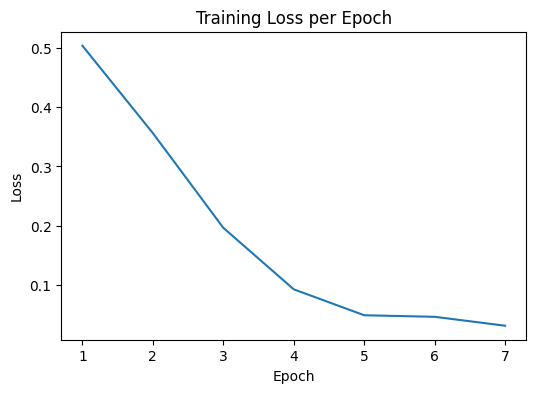

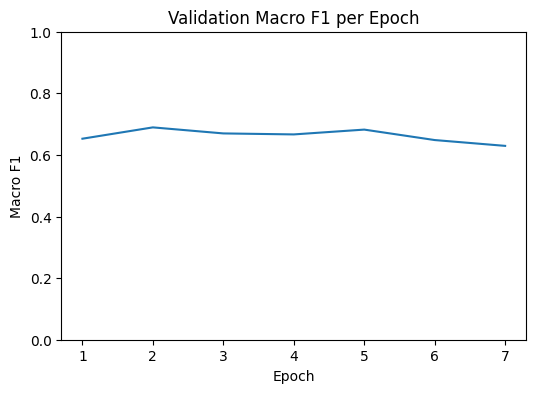

In [ ]:
import matplotlib.pyplot as plt
history = torch.load("/content/drive/MyDrive/DNLP/checkpoints/bert_training_history_sarcasm.pt")

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, history["train_loss"])
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, history["val_f1"])
plt.title("Validation Macro F1 per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Macro F1")
plt.ylim(0, 1)
plt.show()

## Metrics

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import pandas as pd

@torch.no_grad()
def evaluate_overall(model, dataloader):
    model.eval()

    all_preds = []
    all_labels = []
    all_varieties = []  # <--- NEW: Store varieties here

    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attn = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Capture variety if it exists in the batch
        if "variety" in batch:
            all_varieties.extend(batch["variety"].cpu().tolist())

        logits = model(input_ids=input_ids, attention_mask=attn).logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # 1. Global Metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    cm = confusion_matrix(all_labels, all_preds)

    # 2. Per-Variety Breakdown (The logic gap fix)
    if all_varieties:
        print("\n--- Per-Variety Performance ---")

        # Create a temporary dataframe to group by variety
        results_df = pd.DataFrame({
            'label': all_labels,
            'pred': all_preds,
            'variety_id': all_varieties
        })

        # Map IDs back to names (Optional: Update dictionary based on your preprocessing)
        # Assuming: 0: 'en-AU', 1: 'en-IN', 2: 'en-UK', 3: 'en-US', etc.
        # You can pass the actual map if available, otherwise we use IDs.

        # Calculate accuracy per group
        variety_acc = results_df.groupby('variety_id').apply(
            lambda x: accuracy_score(x['label'], x['pred'])
        )
        print("Per-Variety Accuracy:")
        print(variety_acc)

        # Calculate macro F1 per group
        variety_f1 = results_df.groupby('variety_id').apply(
            lambda x: f1_score(x['label'], x['pred'], average="macro")
        )
        print("\nPer-Variety Macro F1:")
        print(variety_f1)
    else:
        print("\nWarning: No variety data found in this dataset split.")

    return acc, f1, cm

# Run the evaluation
test_acc, test_f1, test_cm = evaluate_overall(model, test_loader)

print(f"\nTest accuracy: {test_acc:.4f}")
print(f"Test macro F1: {test_f1:.4f}")
print("Confusion matrix:\n", test_cm)


--- Per-Variety Performance ---
Per-Variety Accuracy:
variety_id
0    0.752022
1    0.879121
2    0.866667
dtype: float64

Per-Variety Macro F1:
variety_id
0    0.696226
1    0.627321
2    0.673430
dtype: float64

Test accuracy: 0.8363
Test macro F1: 0.6916
Confusion matrix:
 [[925 117]
 [ 82  92]]


/tmp/ipython-input-4183510910.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  variety_acc = results_df.groupby('variety_id').apply(
/tmp/ipython-input-4183510910.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  variety_f1 = results_df.groupby('variety_id').apply(


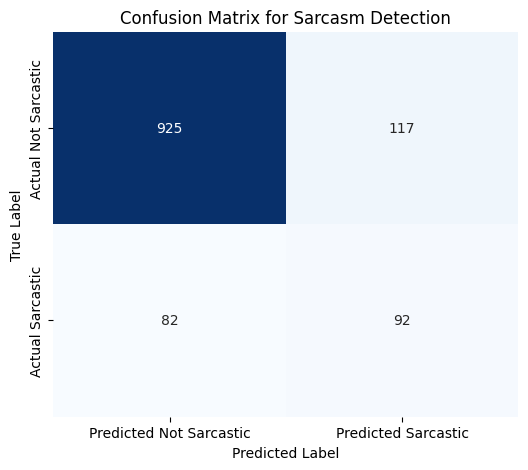

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(
    test_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Predicted Not Sarcastic", "Predicted Sarcastic"],
    yticklabels=["Actual Not Sarcastic", "Actual Sarcastic"]
)
plt.title("Confusion Matrix for Sarcasm Detection")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

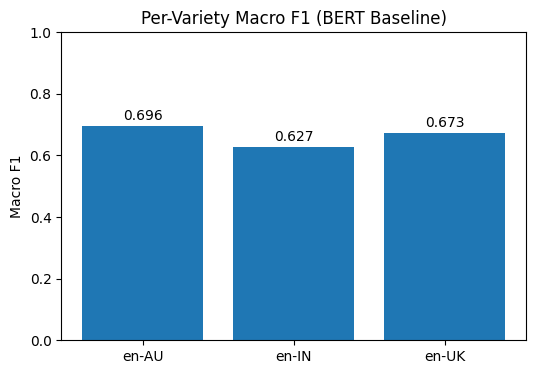

In [ ]:
import matplotlib.pyplot as plt

# Provided mapping from ID to name
variety_id_to_name = {0: 'en-AU', 1: 'en-IN', 2: 'en-UK'}

# Use the per_variety_f1_scores Series directly
# Map variety_id (index) to its descriptive name
varieties = [variety_id_to_name.get(x, str(x)) for x in per_variety_f1_scores.index]
f1s = per_variety_f1_scores.values

plt.figure(figsize=(6, 4))
bars = plt.bar(varieties, f1s)
plt.ylim(0, 1)
plt.ylabel("Macro F1")
plt.title("Per-Variety Macro F1 (BERT Baseline)")

# Always put labels on bars
for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        h + 0.01,
        f"{h:.3f}",
        ha="center",
        va="bottom"
    )

plt.show()

In [ ]:
import pandas as pd

# 1. Create a dictionary containing the BERT baseline Macro F1 scores
bert_baseline_f1_scores = {
    'en-AU': 0.63,
    'en-IN': 0.56,
    'en-UK': 0.62
}

# 2. Convert per_variety_f1_scores to a list of tuples with names
# The variable `per_variety_f1_scores` already exists from previous execution.
# The variable `variety_id_to_name` also exists from previous execution.

our_model_data = []
for variety_id, f1_score in per_variety_f1_scores.items():
    variety_name = variety_id_to_name.get(variety_id, f"Unknown-{variety_id}")
    our_model_data.append({
        'Variety': variety_name,
        'Macro F1': f1_score,
        'Model Type': 'Our Model'
    })

# Prepare BERT Baseline data in the same format
bert_baseline_data = []
for variety_name, f1_score in bert_baseline_f1_scores.items():
    bert_baseline_data.append({
        'Variety': variety_name,
        'Macro F1': f1_score,
        'Model Type': 'Paper'
    })

# 3. Create a pandas DataFrame by concatenating the two lists of dictionaries
comparison_df = pd.DataFrame(our_model_data + bert_baseline_data)

print("Comparison DataFrame created:")
print(comparison_df)

Comparison DataFrame created:
  Variety  Macro F1 Model Type
0   en-AU  0.696226  Our Model
1   en-IN  0.627321  Our Model
2   en-UK  0.673430  Our Model
3   en-AU  0.630000      Paper
4   en-IN  0.560000      Paper
5   en-UK  0.620000      Paper


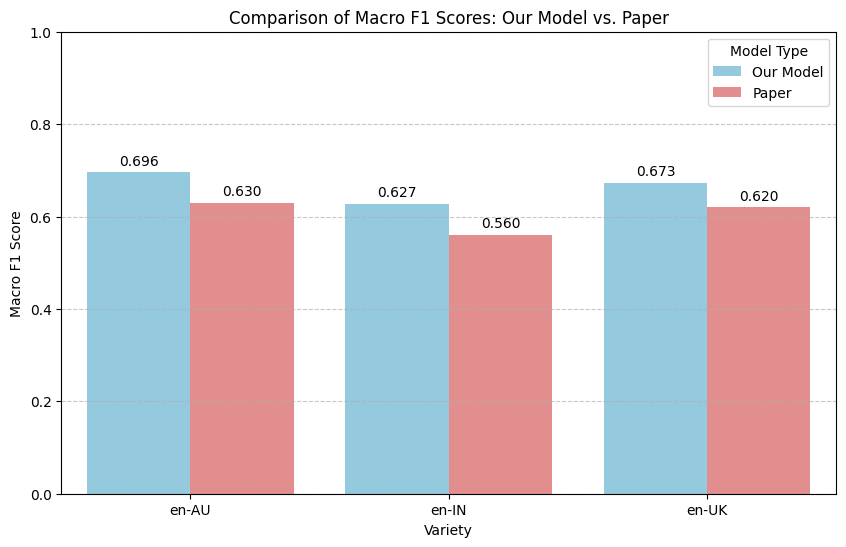

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=comparison_df,
    x='Variety',
    y='Macro F1',
    hue='Model Type',
    palette={'Our Model': 'skyblue', 'Paper': 'lightcoral'}
)

plt.title('Comparison of Macro F1 Scores: Our Model vs. Paper')
plt.xlabel('Variety')
plt.ylabel('Macro F1 Score')
plt.ylim(0, 1) # F1 scores are between 0 and 1
plt.legend(title='Model Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add numbers on each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.show()